In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, backend
import tensorflow as tf
from IPython.display import clear_output

In [2]:
## Importing the tumor-free images and cropping them to size

No = []

imsize = (80, 80)
thresh = 50

for i in os.listdir('Brain_Tumor_Detection/no/'):
    file = 'Brain_Tumor_Detection/no/' + i
    img = np.array(Image.open(file).convert('L'))
    s1,s2 = img.shape
    hmin = np.min(np.argwhere(img[s1//2,:] > thresh))
    hmax = np.max(np.argwhere(img[s1//2,:] > thresh))
    vmin = np.min(np.argwhere(img[:,s2//2-5] > thresh))
    vmax = np.max(np.argwhere(img[:,s2//2-5] > thresh))
    img = img[vmin:vmax,hmin:hmax]
    img = Image.fromarray(img).resize((imsize))
    img = np.array(img)
    No.append(img)

No = np.array(No)

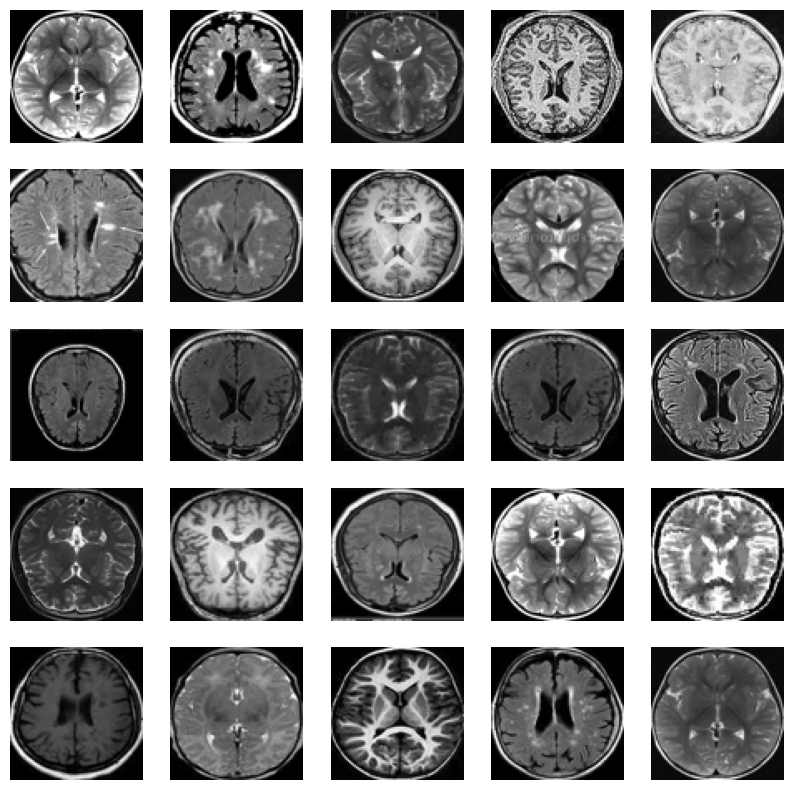

In [3]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(No[r*5+c], cmap='gray')
        ax[r,c].axis('off')
plt.show()

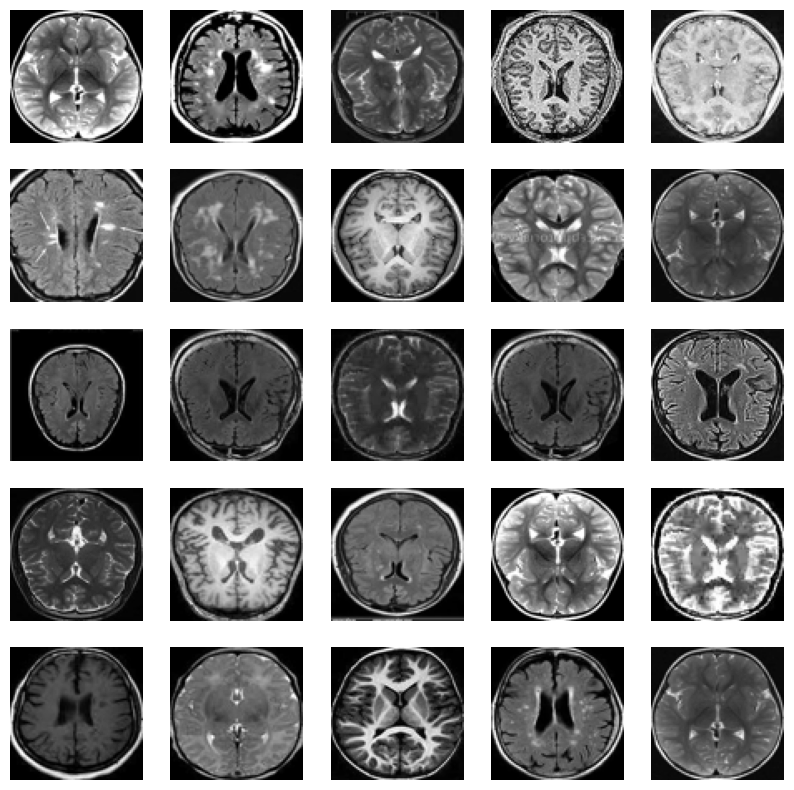

In [4]:
## Normalizing the image files to be between -1 and 1

nNo = (No - 127.5) / 127.5
nNo = nNo.reshape(nNo.shape[0], nNo.shape[1], nNo.shape[2], 1)

fig, ax = plt.subplots(5,5, figsize=(10,10))
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(nNo[r*5+c], cmap='gray')
        ax[r,c].axis('off')
plt.show()

In [5]:
## Creating a function to select n random real images from the dataset

def get_real(data, n):
    i = np.random.randint(0, data.shape[0], n)
    x = data[i]
    y = np.ones(n).reshape((n,1))

    return x,y

In [6]:
## Creating a function that generates n random fake images using the gen generator model

def get_fake(gen, n):
    x = np.random.randn(n * 20 * 20)
    x = x.reshape(n,400)
    
    X = gen.predict(x, verbose=False)
    y = np.zeros(n).reshape((n,1))

    return X,y

In [7]:
backend.clear_session()

In [8]:
## Building the generator model

gen = models.Sequential()
gen.add(layers.Dense(20 * 20 * 256, use_bias=False, input_shape=(20*20,)))
gen.add(layers.LeakyReLU(alpha=0.2))
gen.add(layers.Dropout(0.2))

gen.add(layers.Reshape((20,20,256)))

gen.add(layers.UpSampling2D())
gen.add(layers.Conv2D(32, kernel_size=3, strides=1, use_bias=False, padding='same'))
gen.add(layers.LeakyReLU(alpha=0.2))

gen.add(layers.UpSampling2D())
gen.add(layers.Conv2D(16, kernel_size=3, strides=1, use_bias=False, padding='same'))
gen.add(layers.LeakyReLU(alpha=0.2))

gen.add(layers.BatchNormalization())
gen.add(layers.Conv2D(1, kernel_size=1, strides=1, use_bias=False, padding='same', activation='tanh'))

gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            40960000  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 dropout (Dropout)           (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 20, 20, 256)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 40, 40, 256)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 32)        73728     
                                                        

In [9]:
## Building the discriminator model

disc = models.Sequential()

disc.add(layers.InputLayer(input_shape=(80,80,1)))

disc.add(layers.Conv2D(16, kernel_size=3, strides=1, use_bias=False, padding='same'))
disc.add(layers.LeakyReLU(alpha=0.2))
disc.add(layers.MaxPooling2D())

disc.add(layers.Conv2D(32, kernel_size=3, strides=1, use_bias=False, padding='same'))
disc.add(layers.LeakyReLU(alpha=0.2))
disc.add(layers.MaxPooling2D())

disc.add(layers.Flatten())
disc.add(layers.Dense(16))
disc.add(layers.LeakyReLU(alpha=0.2))

disc.add(layers.Dense(1, activation='sigmoid', use_bias=False))

disc.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 80, 80, 16)        144       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        4608      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                  

In [10]:
## Creating a training set for the driscriminator, combining all real images with an equivalent number and size random arrays

np.random.seed(42)

dX = np.concatenate([nNo, np.random.randn(1490*80*80*1).reshape(1490,80,80,1)], axis=0)

dX.shape

(2980, 80, 80, 1)

In [11]:
## Creating a training set of Y labels, where real images are labeled 1 and fake images are labeled 0

dY = np.ones((1490,1))
dY = np.concatenate([dY, np.zeros((1490,1))])
dY.shape

(2980, 1)

In [12]:
## Training the discriminator model

np.random.seed(42)

disc.fit(dX,dY, epochs=1)

94/94 [==============================] - 9s 91ms/step - loss: 0.0347 - accuracy: 0.9758


In [13]:
## Creating a function that generates a GAN model from a generator and discriminator. The driscriminator will not be trained when fitting the GAN model and will be updated separately

def GAN(g, d):
    d.trainable = False
    gan = models.Sequential()
    gan.add(g)
    gan.add(d)

    gan.compile(optimizer='adam', loss='binary_crossentropy')

    return gan

gan = GAN(gen, disc)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 80, 80, 1)         41038416  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 209584    
                                                                 
Total params: 41,248,000
Trainable params: 41,038,384
Non-trainable params: 209,616
_________________________________________________________________


In [14]:
## Creating a training function that takes in the models, a dataset, a number of epochs, and the number of images per batch in each epoch
##
## A dataset of n_batch datapoints is generated using half real images and half fake images created by the generator
## The discriminator is then trained using the dataset, where the generated images will be updated each epoch.
## Once retrained, the generator will be trained by fitting the GAN with random arrays and labeling them as real images.
## The generator will then work to find the best parameters that generates an image that can fool the discriminator.
## Finally, after each epoch, a sample image is displayed and the accuracy of the discriminator is printed.

def train_gan(generator, discriminator, GAN, dataset, n_epochs=10, n_batch=745):
    batches = dataset.shape[0] // n_batch
    steps = batches * n_epochs
    hb = n_batch // 2

    for i in range(steps):
        dx, dy = get_real(dataset, hb)
        gx, gy = get_fake(generator, hb)
        x = np.concatenate([dx, gx], axis=0)
        y = np.concatenate([dy, gy], axis=0)
        
        if i % batches == 0:
            clear_output(wait=True)
            print('Epoch {}'.format(i//batches))
            
            predY = np.round(disc.predict(x, verbose=False), 0)
            realacc = np.mean(predY[y == 1] == 1)
            fakeacc = np.mean(predY[y == 0] == 0)
            print("Real Acc: {}         Fake Acc: {}".format(realacc, fakeacc))

            newX = np.random.randn(400).reshape(1,400)
            newImg = gen.predict(newX, verbose=False)
            newImg = (newImg + 1) / 2
            plt.figure(figsize=(2,2), frameon=False)
            plt.imshow(newImg.reshape(80,80), cmap='gray', interpolation='bicubic')
            plt.axis('off')
            plt.show()

        discriminator.fit(x, y, verbose=False)

        X = np.random.randn(n_batch * 20 * 20).reshape(n_batch, 400)
        Y = np.ones((n_batch, 1))

        GAN.fit(X, Y, verbose=False)

Epoch 0
Real Acc: 0.9946236559139785         Fake Acc: 0.9919354838709677


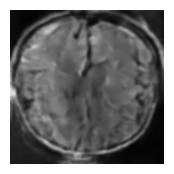

In [74]:
train_gan(gen, disc, gan, nNo, n_epochs=1, n_batch=745) # 500 epochs total

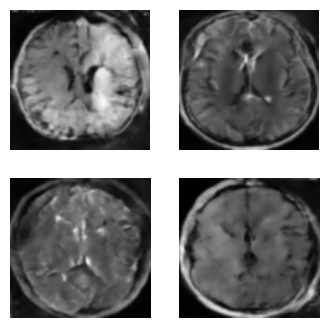

In [75]:
## Visualizing 25 fake images

newXs = np.random.randn(4*400).reshape(4,400)
newImgs = gen.predict(newXs, verbose=False)
newImgs = (newImgs + 1) / 2

fig, ax = plt.subplots(2,2, figsize=(4,4), frameon=False)
for r in range(2):
    for c in range(2):
        i = r*2 + c
        ax[r,c].imshow(newImgs[i].reshape(80,80), cmap='gray', interpolation='bicubic')
        ax[r,c].axis('off')
plt.show()

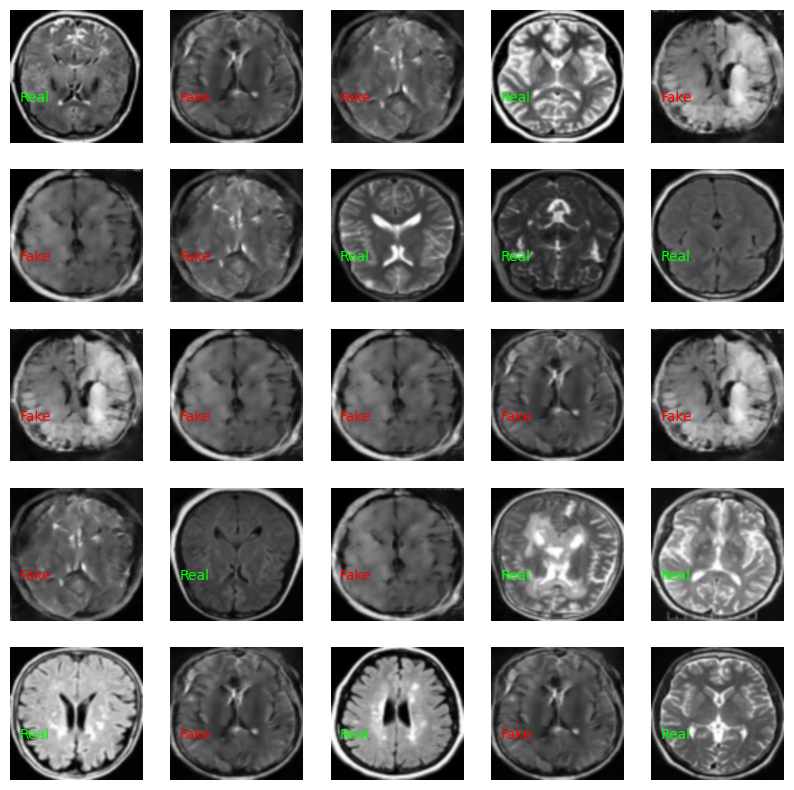

In [76]:
## Visualization of synthetic and real images

fig, ax = plt.subplots(5,5, figsize=(10,10), frameon=False)
for r in range(5):
    for c in range(5):
        rn = np.random.randn()
        if rn > 0:
            s = 'Fake'
            ax[r,c].imshow(newImgs[np.random.randint(0,len(newImgs))].reshape(80,80), cmap='gray', interpolation='bicubic')
            ax[r,c].axis('off')
            ax[r,c].text(x=5, y=55, s=s, c=(1,0,0))
        else:
            s = 'Real'
            ax[r,c].imshow(nNo[np.random.randint(0,len(nNo))].reshape(80,80), cmap='gray', interpolation='bicubic')
            ax[r,c].axis('off')
            ax[r,c].text(x=5, y=55, s=s, c=(0,1,0))
plt.show()

The GAN built does an alright job of generating fake brain scans but it is still easily discernable between real and fake images. Additional parameter tuning, further training, or additional tweaks may increase the quality of the fake images.

In [15]:
# Loading the weights after constructing the models. This was used to train the model in multiple sessions as each epoch took about a minute.

disc.load_weights('disc.h5')
gen.load_weights('gen.h5')
gan.load_weights('gan.h5')

In [60]:
# Saving the model and weights

gen_json = gen.to_json()
disc_json = disc.to_json()
gan_json = gan.to_json()

with open("gen.json", "w") as json_file:
    json_file.write(gen_json)

with open("disc.json", "w") as json_file:
    json_file.write(disc_json)

with open("gan.json", "w") as json_file:
    json_file.write(gan_json)

gen.save_weights('gen.h5')
disc.save_weights('disc.h5')
gan.save_weights('gan.h5')

